In [1]:
import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from HRIRDataset import HRIRDataset
from HRIRTransformerModel import HRIRTransformerModel
import matplotlib.pyplot as plt
from CombinedLoss import CombinedLoss

In [2]:
sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
hrir_dataset = HRIRDataset()
for i in range(1,4):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))

In [3]:
len(hrir_dataset)

216

In [5]:
for i in hrir_dataset[0]:
    print(i.shape)

torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([])


In [17]:
import torch
import torch.nn as nn
from PositionalEncoding import PositionalEncoding
import torch.nn.functional as F
class MyClass(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.5, sos_token=0, eos_token=-3):
        super(MyClass, self).__init__()
        self.attention_weights = nn.Linear(d_model, 1)

        self.sos_token = sos_token
        self.eos_token = eos_token

        self.pos_encoder = PositionalEncoding(d_model)
        
        # Encoder setup
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                        dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        
        # Decoder setup
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                        dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        
        # Adjusting the model to output a single HRIR channel
        # Assuming d_model is the dimensionality you want for the HRIR (e.g., 512)
        self.final_projection = nn.Linear(d_model, d_model)
        self.reduce_to_single_channel = nn.Linear(nhead * num_decoder_layers, 1)  # Adjust for your architecture specifics
        self.d_model = d_model
    
    def forward(self, src_with_angle, target_sequence=None):
        # print(src_with_angle.shape) # torch.Size([32, 3, 192])
        # Assuming src_with_angle is a tensor of shape [batch, seq_len, features]
        src_with_angle = src_with_angle.permute(1, 0, 2)  # Shape: [seq_len, batch, features]
        src_with_angle = self.pos_encoder(src_with_angle)
        memory = self.transformer_encoder(src_with_angle)
        
        if target_sequence is not None:
            # If a target sequence is provided, use it as the input to the decoder
            # Ensure it's permuted correctly to [seq_len, batch, features] if not already
            target_sequence = target_sequence.permute(1, 0, 2)
            target_sequence = self.pos_encoder(target_sequence)
            decoder_input = target_sequence
        else:
            # If no target is provided, create a dummy sequence for decoder input
            dummy_sequence = torch.full(src_with_angle.size(), fill_value=self.sos_token, device=src_with_angle.device)
            dummy_sequence = self.pos_encoder(dummy_sequence)
            decoder_input = dummy_sequence
        
        # Process through the decoder
        output = self.transformer_decoder(decoder_input, memory)
        output = output.permute(1, 0, 2)
        # Compute attention scores
        attn_scores = self.attention_weights(output).squeeze(-1)  # Shape: [batch, seq_len]
        attn_weights = F.softmax(attn_scores, dim=-1).unsqueeze(-1)  # Shape: [batch, seq_len, 1]
        
        # # Apply attention weights
        output_attended = torch.sum(output * attn_weights, dim=1, keepdim=True)  # Shape: [batch, 1, features]
        # output_attended = output_attended.permute() # Shape: [batch, 1, features]
        # print(output_attended.shape)
        
        return output_attended
        # print(output.shape)
        # return output


In [41]:
import math
import torch
import torch.nn as nn
from PositionalEncoding import PositionalEncoding
import torch.nn.functional as F
class HRIRTransformerModel(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, angle_dim, dropout=0.5, max_len=512):
        super(HRIRTransformerModel, self).__init__()
        
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.angle_encoder = nn.Linear(1, angle_dim)  # Encodes angle to a high-dimensional space
        self.encoder = nn.Linear(192 + angle_dim, d_model)  # Adjusted for concatenated angles
        self.decoder = nn.Linear(d_model, 182)  # Output HRIR prediction
        self.d_model = d_model
        self.angle_dim = angle_dim
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.angle_encoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, b0, b90, b180, b270, angle, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None, memory_key_padding_mask=None):
        angle_zero_encoded = self.angle_encoder(torch.tensor([[0.0]]))  # Encode angle zero as zero
        angle_90_encoded = self.angle_encoder(torch.tensor([[90.0]]))  # Encode angle 90 as 90
        angle_180_encoded = self.angle_encoder(torch.tensor([[180.0]]))  # Encode angle 180 as 180
        angle_270_encoded = self.angle_encoder(torch.tensor([[270.0]]))  # Encode angle 270 as 270

        

        # print(angle_zero_encoded.shape)
        
        # encoded_angles = []
        # print(angles)
        # for angle in angles:
        #     print("Start for, ", angle.shape)
        #     angle_encoded = self.angle_encoder(angle.view(-1, 1)).unsqueeze(1)  # Encode each angle
        #     print(angle_encoded.shape)
        #     angle_encoded = angle_encoded.expand(-1, b0.size(1), -1)
        #     print(angle_encoded.shape)
        #     encoded_angles.append(angle_encoded)  # Expand dimensions to match src
        
        # Concatenate the encoded angles with the HRIR data
        concatenated_inputs = torch.cat([src] + [angle_zero_encoded] + encoded_angles, dim=-1)
        
        src = self.encoder(concatenated_inputs) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_padding_mask)
        tgt = self.pos_encoder(tgt * math.sqrt(self.d_model))
        output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=None, tgt_key_padding_mask=tgt_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = self.decoder(output)
        return output



In [42]:
hrir_dataset[0][-1]

tensor(0., dtype=torch.float64)

In [43]:
# Test the forward method
model = HRIRTransformerModel(d_model=192, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, angle_dim=64)
# load first iteam from the dataset
data = hrir_dataset[0]
b0, b90, b180, b270, target, angles = data
b0, b90, b180, b270, angles, target = b0.float(), b90.float(), b180.float(), b270.float(), angles.float(), target.float()
output = model(b0=b0, b90=b90, b180=b180, b270=b270, angles=angles.unsqueeze(0), tgt=target)
output.shape

torch.Size([1, 64])
tensor([0.])
Start for,  torch.Size([])
torch.Size([1, 1, 64])
torch.Size([1, 512, 64])


UnboundLocalError: local variable 'src' referenced before assignment

In [ ]:
import torch.optim as optim
import torch
device = torch.device('cuda')
model = HRIRTransformerModel(d_model=192, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, angle_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
# weighted_positions = list(range(50, 250))
weighted_positions = None
loss_function = CombinedLoss(alpha=0.2, weighted_positions=weighted_positions, weight=50).to(device) # Lower the alpha value to give more weight to the time
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


In [9]:
train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.2 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])

In [10]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [11]:
target_folder = '/workspace/fourth_year_project/HRTF Models/positional_encoding_models/'
# Create it if it doesn't exist
import os
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [15]:
def normalize(tensor):
    """
    Normalize a tensor to have values between -1 and 1
    """
    return (tensor - tensor.min()) / (tensor.max() - tensor.min()) * 2 - 1

def add_angle(tensor, angle):
    """
    Add angle to the channel dimension of the tensor
    [batch_size, 1, seq_len] -> [batch_size, 2, seq_len]

    Tensor is shape [32, 1, 512]
    Angle is shape [32]
    Expand angle to match the sequence length [32, 1, 512]
    Concatenate along the channel dimension [32, 2, 512]
    """
    angle_expanded = angle.unsqueeze(-1).unsqueeze(1).expand(-1, 1, tensor.size(2))
    
    # Concatenate the expanded angle tensor with the original tensor along the channel dimension
    tensor_with_angle = torch.cat([tensor, angle_expanded], dim=1)
    
    return tensor_with_angle

def add_sos_and_eos(batch_sequences, sos_value, eos_value):
    """
    Extend each sequence in the batch to include distinct SOS and EOS tokens.
    
    Args:
        batch_sequences (Tensor): Input tensor of shape [batch_size, 2, seq_len].
        sos_value (int or float): The value to use for the SOS token.
        eos_value (int or float): The value to use for the EOS token.
        
    Returns:
        Tensor: Modified batch with SOS at the beginning and EOS at the end, shape [batch_size, 2, seq_len + 2].
    """
    batch_size, channels, seq_len = batch_sequences.shape
    # Create tensors for SOS and EOS tokens for the whole batch
    sos_tokens = torch.full((batch_size, channels, 1), sos_value, dtype=batch_sequences.dtype, device=batch_sequences.device)
    eos_tokens = torch.full((batch_size, channels, 1), eos_value, dtype=batch_sequences.dtype, device=batch_sequences.device)
    
    # Concatenate the SOS token at the beginning and the EOS token at the end
    extended_sequences = torch.cat([sos_tokens, batch_sequences, eos_tokens], dim=-1)
    
    return extended_sequences



def add_sos_and_eos_in_place(batch_sequences, sos_value, eos_value):
    """
    Replace the first and last values in each sequence of the batch with SOS and EOS tokens, respectively,
    keeping the sequence length unchanged.
    
    Args:
        batch_sequences (Tensor): Input tensor of shape [batch_size, 2, seq_len].
        sos_value (int or float): The value to use for the SOS token.
        eos_value (int or float): The value to use for the EOS token.
        
    Returns:
        Tensor: Modified batch with the first and last values replaced by SOS and EOS, respectively,
                shape [batch_size, 2, seq_len].
    """
    # Directly replace the first value of each sequence with the SOS token
    batch_sequences[:, :, 0] = sos_value
    
    # Directly replace the last value of each sequence with the EOS token
    batch_sequences[:, :, -1] = eos_value
    
    return batch_sequences

def remove_data(tensor, start_index, end_index):
    """
    Remove data from the tensor along the sequence dimension.
    ex: [batch_size, 2, seq_len] -> [batch_size, 2, start_index --> End_index]
    """
    return tensor[:, :, start_index:end_index]

def preprocess(src, target, angle, device):
    """
    Preprocess the src, target, and angle tensors for training.

    Keeps left channel, adds a channel dimension, converts to float, and normalizes.
    Then adds angle to channel dimension. 
    """
    # Move to the specified device
    src, target, angle = src.to(device), target.to(device), angle.to(device)
    # Select the left channel and add a channel dimension
    # src = src[:, 0, :].unsqueeze(1)
    target = target[:, 0, :].unsqueeze(1)
    # Convert to float and normalize
    src = normalize(src.float())
    target = normalize(target.float())
    src = src.float()
    target = target.float()
    angle = angle.float()

    # src = add_angle(src, angle)
    # target_to_pass = add_angle(target, angle)

    src = remove_data(src, 64, 256)
    target = remove_data(target, 64, 256)
    target_to_pass = target
    # print(src.shape, target.shape, angle.shape)
    # target = add_angle(target, angle)

    # src = add_sos_and_eos_in_place(src, sos_value=-2, eos_value=-3)
    # target = add_sos_and_eos_in_place(target, sos_value=-2, eos_value=-3)

    # src = src.permute(0, 2, 1)
    # target = target.permute(0, 2, 1)
    # print(src.shape, target.shape, angle.shape) # torch.Size([32, 3, 192]) torch.Size([32, 1, 192]) torch.Size([32])

    return src, angle, target, target_to_pass

In [16]:


def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for src, target, angle in data_loader:
        # Adjust preprocessing to include shifting the target for teacher forcing
        src, angle, target, target_to_pass = preprocess(src, target, angle, device)
        src = src.to(device)
        target = target.to(device)
        target_to_pass = target_to_pass.to(device)
        # src - [batch_size, 2, 512], with angle, SOS, EOS
        # taret - [batch_size, 1, 512], with angle, SOS, EOS
        # if random generated number is less than 0.5, use target_to_pass
        # if torch.rand(1) < 1.1:
        output = model(src, angle, target_to_pass)
        # else:
            # output = model(src)
        # Only keep the first channel
        # output = output[:, 0, :].unsqueeze(1)
        # print("output: ", output.shape, target.shape)
        
        # output = output[:, :2, :]
        # remove the SOS and EOS tokens from output and target
        # output = output[:, :, 1:-1]
        # target = target[:, :, 1:-1]
        
        # Compute loss
        # Ensure the loss is calculated against the original target, not the shifted one
        loss = loss_function(output, target)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Update the learning rate
    scheduler.step()
    
    return total_loss / len(data_loader)

def validate_epoch(model, data_loader, loss_function, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, target, angle in data_loader:
            src, angle, target, target_to_pass = preprocess(src, target, angle, device)
            src = src.to(device)
            target = target.to(device)
            output = model(src, angle, target_to_pass)
            # Only keep the first channel
            # output = output[:, 0, :].unsqueeze(1)
            # output = output[:, :2, :]
            # remove the SOS and EOS tokens from output and target
            # output = output[:, :, 1:-1]
            # target = target[:, :, 1:-1]
            
            # Compute loss
            loss = loss_function(output, target)
            
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [17]:

num_epochs = 200 # Number of epochs to train for
model = model.to(device)  # Move model to the specified device
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 1, Train Loss: 2.2035, Validation Loss: 1.2664
Epoch 2, Train Loss: 1.3878, Validation Loss: 1.1621
Epoch 3, Train Loss: 1.2676, Validation Loss: 1.0322
Epoch 4, Train Loss: 1.2238, Validation Loss: 1.1381
Epoch 5, Train Loss: 1.1925, Validation Loss: 1.3823
Epoch 6, Train Loss: 1.0580, Validation Loss: 1.1280
Epoch 7, Train Loss: 1.0685, Validation Loss: 1.0742
Epoch 8, Train Loss: 1.0463, Validation Loss: 1.1775
Epoch 9, Train Loss: 1.0292, Validation Loss: 1.1162
Epoch 10, Train Loss: 1.0674, Validation Loss: 1.1007
Epoch 11, Train Loss: 1.0418, Validation Loss: 1.0252
Epoch 12, Train Loss: 1.0677, Validation Loss: 1.1178
Epoch 13, Train Loss: 0.9921, Validation Loss: 1.1576
Epoch 14, Train Loss: 1.0150, Validation Loss: 1.0820
Epoch 15, Train Loss: 0.9910, Validation Loss: 1.0727
Epoch 16, Train Loss: 1.0104, Validation Loss: 1.0623
Epoch 17, Train Loss: 1.0257, Validation Loss: 1.1243
Epoch 18, Train Loss: 1.0287, Validation Loss: 1.0745
Epoch 19, Train Loss: 1.0361, Validat

KeyboardInterrupt: 

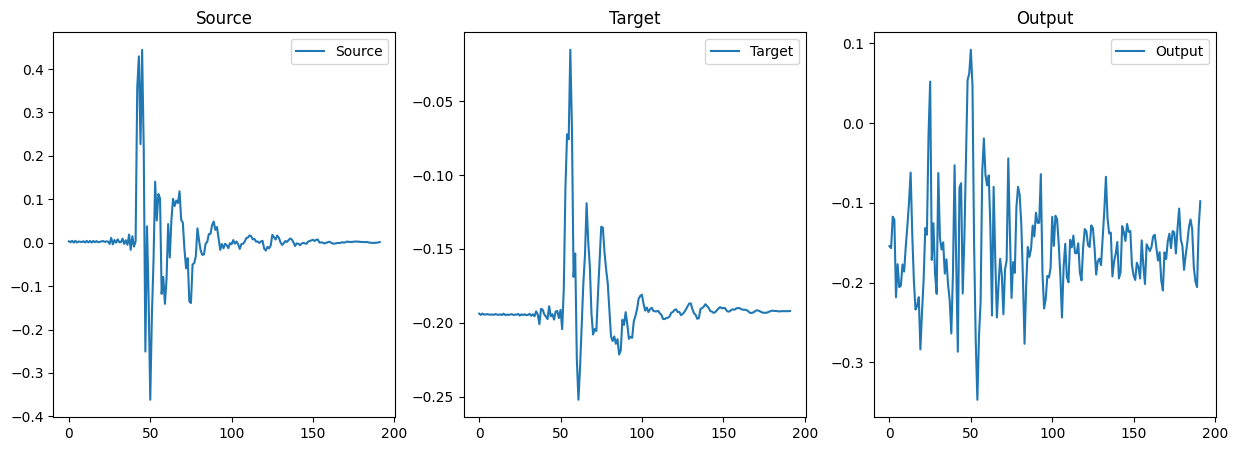

Loss: 0.7645


In [19]:
import matplotlib.pyplot as plt

def test_and_plot(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # No need to track gradients
        # Get one batch from the test_loader
        for src, target, angle in test_loader:
            # Move to the specified device
            src, angle, target, t = preprocess(src, target, angle, device)
            
            # Forward pass to get the output from the model
            output = model(src, angle,t)
            # Only keep the first channel
            # output = output[:, 0, :].unsqueeze(1)
            # remove the SOS and EOS tokens from output and target
            # src = src[:, :, 1:-1]
            # output = output[:, :, 1:-1]
            # target = target[:, :, 1:-1]
            
            # Plot the first sample in the batch for src, target, and output
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.plot(src[0, 0].cpu().numpy(), label='Source')
            plt.title('Source')
            plt.legend()
            
            plt.subplot(1, 3, 2)
            plt.plot(target[0, 0].cpu().numpy(), label='Target')
            plt.title('Target')
            plt.legend()
            
            plt.subplot(1, 3, 3)
            plt.plot(output[0, 0].cpu().numpy(), label='Output')
            plt.title('Output')
            plt.legend()
            
            plt.show()

            # Print out the loss
            loss = loss_function(output, target)
            print(f'Loss: {loss.item():.4f}')
            
            # Since we only want to plot for the first element, break after the first batch
            break


# Assuming you have a model, test_loader, and device defined
test_and_plot(model, test_loader, device)


In [ ]:
# Load first src, tgt from test_loader
src, tgt, angle = next(iter(test_loader))
src, tgt = preprocess(src, tgt, angle, device)


In [ ]:
tgt[0,0,:]

tensor([-3.4896e-04,  1.4307e-04, -2.6465e-04,  2.3409e-04, -5.0074e-05,
         1.3366e-04,  1.9848e-04, -1.5799e-04,  3.5974e-04, -7.8434e-05,
        -1.5704e-05, -5.0496e-06, -1.3179e-04, -1.2366e-04, -2.4998e-04,
        -2.0870e-04, -3.4875e-04, -4.5381e-04, -4.8260e-04, -4.6456e-04,
        -7.1003e-04, -6.2319e-04, -6.1956e-04, -5.7537e-04, -6.5778e-04,
        -5.3146e-04, -3.8710e-04, -3.9402e-04, -4.4124e-04, -5.2894e-04,
        -3.8697e-04, -4.9396e-04, -4.6619e-04, -4.7452e-04, -5.5298e-04,
        -5.3920e-04, -4.9414e-04, -6.0076e-04, -6.1087e-04, -6.6884e-04,
        -7.6535e-04, -6.3662e-04, -7.8022e-04, -6.8192e-04, -7.9555e-04,
        -6.6413e-04, -7.1615e-04, -6.6129e-04, -7.1315e-04, -7.4590e-04,
        -6.0778e-04, -8.2429e-04, -6.3389e-04, -9.3051e-04, -7.8589e-04,
        -8.2451e-04, -9.2087e-04, -8.9335e-04, -1.0241e-03, -9.9160e-04,
        -9.5516e-04, -8.7336e-04, -1.0027e-03, -9.0699e-04, -1.0996e-03,
        -8.2967e-04, -8.4489e-04, -9.2411e-04, -8.0

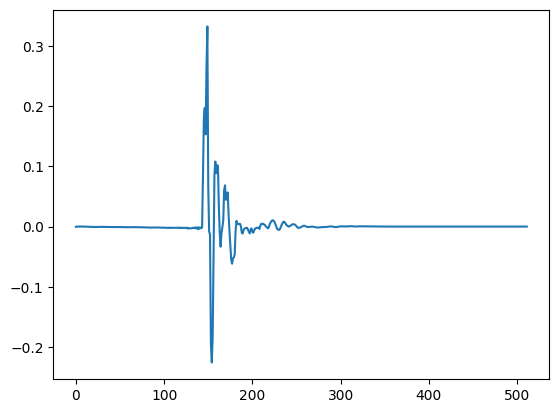

In [ ]:
plt.plot(tgt[0, 0,:].cpu().numpy(), label='Target')